In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match", triviaqa="match", cnn_dailymail="rougeL", wikitext_bpc="bpc"
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        if task == "wikitext_bpc":
            scores = scores[:100]
        assert len(scores) == dict(squad=1000, triviaqa=1000, cnn_dailymail=500, wikitext_bpc=100)[task]
        return dict(
            task=task,
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

df = (
    pd.concat([load_sweep("RMOE-65-refresh"), load_sweep("RMOE-64-sparse-q-L2")]).reset_index()
    .pipe(lambda d: d.assign(reallocate_to_mean_value=d.reallocate_to_mean_value.map(lambda x: {True: "L1"}.get(x, x))))
    [["task", "model", "name", "k", "rank", "reallocate_to_mean_value", "score", "score_stderr"]]
)
df.head()

,task,model,name,k,rank,reallocate_to_mean_value,score,score_stderr
0,cnn_dailymail,pythia-1.4b,ann,256.0,64.0,L1,0.177893,0.003821
1,cnn_dailymail,pythia-1.4b,ann,256.0,32.0,L1,0.178907,0.003778
2,wikitext_bpc,pythia-2.8b,ann,128.0,16.0,L1,0.752117,0.012924
3,cnn_dailymail,pythia-1.4b,ann,256.0,16.0,L1,0.181286,0.003786
4,cnn_dailymail,pythia-1.4b,ann,128.0,64.0,L1,0.180038,0.003875


In [5]:
pd.options.display.max_rows = 100
df[df.name=="ann"].pivot(index=["task", "model", "k", "rank"], columns="reallocate_to_mean_value", values="score").pipe(lambda s: s[s.apply(lambda r: (~r.isna()).sum() >= 2, axis=1)])

reallocate_to_mean_value                   L0        L1        L2
task         model       k     rank                              
squad        llama-2-7b  32.0  16.0  0.730000  0.380000  0.204000
                               32.0  0.746000  0.447000  0.294000
                               64.0  0.702000  0.488000  0.367000
                         64.0  16.0  0.727000  0.694000  0.392000
                               32.0  0.735000  0.755000  0.598000
                               64.0  0.748000  0.760000  0.754000
                         128.0 16.0  0.664000  0.742000  0.720000
                               32.0  0.686000  0.755000  0.756000
                               64.0  0.732000  0.759000  0.760000
                         256.0 16.0       NaN  0.752000  0.758000
                               32.0       NaN  0.761000  0.763000
                               64.0       NaN  0.762000  0.764000
             pythia-1.4b 32.0  16.0  0.388000  0.389000  0.378000
                               32.0  0.404000  0.396000  0.389000
                               64.0  0.406000  0.407000  0.404000
                         64.0  16.0  0.400000  0.398000  0.391000
                               32.0  0.399000  0.401000  0.403000
                               64.0  0.409000  0.416000  0.415000
                         128.0 16.0  0.406000  0.408000  0.406000
                               32.0  0.420000  0.418000  0.412000
                               64.0  0.419000  0.417000  0.414000
                         256.0 16.0       NaN  0.412000  0.412000
                               32.0       NaN  0.421000  0.420000
                               64.0       NaN  0.423000  0.418000
             pythia-6.9b 32.0  16.0       NaN  0.559000  0.563000
                               32.0       NaN  0.575000  0.574000
                               64.0       NaN  0.579000  0.571000
                         64.0  16.0       NaN  0.574000  0.565000
                               32.0       NaN  0.577000  0.576000
                               64.0       NaN  0.577000  0.571000
                         128.0 16.0       NaN  0.577000  0.569000
                               32.0       NaN  0.575000  0.572000
                               64.0       NaN  0.574000  0.569000
                         256.0 16.0       NaN  0.574000  0.572000
                               32.0       NaN  0.574000  0.568000
                               64.0       NaN  0.574000  0.568000
wikitext_bpc llama-2-7b  32.0  16.0  0.840934  0.857139  1.002818
                               32.0  0.827268  0.833208  0.899594
                               64.0  0.816638  0.832878  0.863060
                         64.0  16.0  0.817227  0.807624  0.799714
                               32.0  0.812363  0.800991  0.804567
                               64.0  0.807027  0.800473  0.801484
                         128.0 16.0  0.802158  0.797676  0.787782
                               32.0  0.800439  0.795565  0.795260
                               64.0  0.797401  0.794856  0.795503
                         256.0 16.0       NaN  0.792427  0.792846
                               32.0       NaN  0.791362  0.791610
                               64.0       NaN  0.790622  0.791351
             pythia-1.4b 32.0  16.0  0.858667       NaN  0.861406
                               32.0  0.838850       NaN  0.844990
                               64.0  0.811716       NaN  0.821709
                         64.0  16.0  0.838672       NaN  0.838940
                               32.0  0.823340       NaN  0.826689
                               64.0  0.801758       NaN  0.806638
                         128.0 16.0  0.822898       NaN  0.822263
                               32.0  0.810364       NaN  0.812705
                               64.0  0.797012       NaN  0.799258
             pythia-6.9b 32.0  16.0       NaN  0.728164  0.741479
                               32.0     

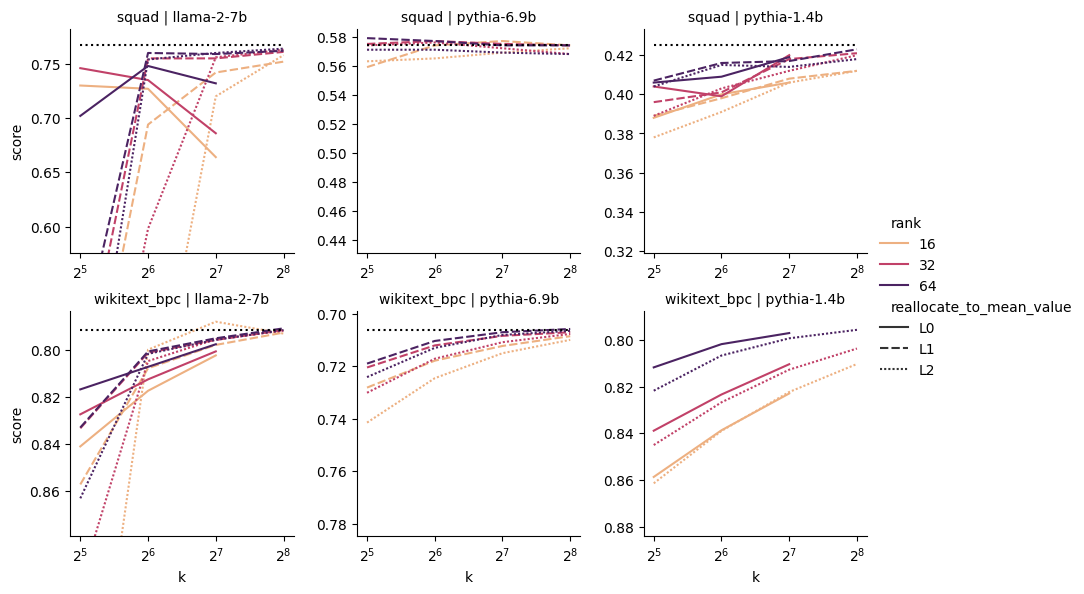

In [6]:
g = sns.relplot(data=df.pipe(lambda d: d[d.name=="ann"]).pipe(lambda d: d.assign(rank=d["rank"].astype("long"))),
                y="score", x="k",
                hue="rank", hue_norm=matplotlib.colors.LogNorm(),
                style="reallocate_to_mean_value", style_order=["L0", "L1", "L2"], palette="flare",
                row="task", row_order=["squad", "wikitext_bpc"],
                col="model", col_order=["llama-2-7b", "pythia-6.9b", "pythia-1.4b"],
                kind="line", facet_kws=dict(sharex=False, sharey=False), height=3)

for (task, model), ax in g.axes_dict.items():
    ax.set_xscale("log", base=2)
    ax.set_title(f"{task} | {model}", fontsize=10)
    b = df[(df.task == task) & (df.model == model) & (df.name == "dense")]
    bscore = b.score.item() if len(b) else df[(df.task == task) & (df.model == model)].score.quantile(0 if task == "wikitext_bpc" else 1)
    if len(b):
        ax.hlines(bscore, 2**5, 2**8, colors="k", linestyles=":")
    ax.set_ylim((bscore/.9, bscore/1.01) if task == "wikitext_bpc" else (bscore*.75, bscore*1.02))